# Dissecting Spotify Valence

---

> Author : Georgios Zachariadis <br />




Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

In this occasion,our aim is to untangle the mystery behind valence and propose how this is derived.

Spotify offers the following information

* [Get Track's Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) and [Get Tracks' Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

* [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis).


---
## Explore which Features Influence Valence

We will use inferential statistic methods to study how features (track and possibly audio) influence valence. As a result we will have the best possible model for explaining the valence based on the features that we find significant.

---

## To begin with, I want to highlight the fact that I tested two datasets for this assignment. As far as the first dataset is concerned [from Zenodo link (https://zenodo.org/record/4778563) used the spotify_hits_dataset] we didn't get promising scores. Therefore, for this assignment I used the SpotifyDataset from Kaggle (https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db). Below we begin with the EDA of our dataset.

In [1]:
import pandas as pd
from tqdm import tqdm

# read dataset
datasets_path = 'dataset/SpotifyFeatures.csv'
spotify_dataset = pd.read_csv(datasets_path)

# convert useful categorical varibales
spotify_dataset['mode'] = spotify_dataset['mode'] .apply(lambda x: 1 if x == 'Major' else 0)
spotify_dataset = pd.get_dummies(spotify_dataset, columns=['genre', 'key'], sparse=False)

In [2]:
spotify_dataset.columns

Index(['artist_name', 'track_name', 'track_id', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'genre_A Capella', 'genre_Alternative', 'genre_Anime', 'genre_Blues',
       'genre_Children's Music', 'genre_Children’s Music', 'genre_Classical',
       'genre_Comedy', 'genre_Country', 'genre_Dance', 'genre_Electronic',
       'genre_Folk', 'genre_Hip-Hop', 'genre_Indie', 'genre_Jazz',
       'genre_Movie', 'genre_Opera', 'genre_Pop', 'genre_R&B', 'genre_Rap',
       'genre_Reggae', 'genre_Reggaeton', 'genre_Rock', 'genre_Ska',
       'genre_Soul', 'genre_Soundtrack', 'genre_World', 'key_A', 'key_A#',
       'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F',
       'key_F#', 'key_G', 'key_G#'],
      dtype='object')

In [3]:
# check for null objects
spotify_dataset.isna().sum()

artist_name               0
track_name                0
track_id                  0
popularity                0
acousticness              0
danceability              0
duration_ms               0
energy                    0
instrumentalness          0
liveness                  0
loudness                  0
mode                      0
speechiness               0
tempo                     0
time_signature            0
valence                   0
genre_A Capella           0
genre_Alternative         0
genre_Anime               0
genre_Blues               0
genre_Children's Music    0
genre_Children’s Music    0
genre_Classical           0
genre_Comedy              0
genre_Country             0
genre_Dance               0
genre_Electronic          0
genre_Folk                0
genre_Hip-Hop             0
genre_Indie               0
genre_Jazz                0
genre_Movie               0
genre_Opera               0
genre_Pop                 0
genre_R&B                 0
genre_Rap           

### We are going to use a class to handle better our dataset. Below you could see the implementation.

In [4]:
# class which we are going to use to handle fetches from Spotify API
# spotipy module necessary
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials 
from tqdm import tqdm

class SpotifyHandler:
    def __init__(self, dataset):
        # credentials for Spotify API 
        client_id = 'XXXXXXXXXXXXX'     # yours client token
        client_secret = 'XXXXXXXXXXXXX'  # yours client secret token
        client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
        self.sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
        
        # read dataset and convert categorical
        self.dataset = pd.read_csv(dataset)
        self.dataset['mode'] = self.dataset['mode'] .apply(lambda x: 1 if x == 'Major' else 0)
        # key notes taken from Wikipedia
        key_notes = {'C':0, 'C#':1, 'D':2, 'D#':3, 'E':4, 'F':5, 'F#':6, 'G':7, 'G#':8, 'A':9, 'A#':10, 'B':11}
        self.dataset=self.dataset.replace({"key": key_notes})
    
    # method which help us fetch test track ids from Spotify API
    def fetch_data(self, test_data_list):
        test_dataset = list()
        for track_id in tqdm(test_data_list, desc='Fetching..'):
            test_dataset.append(self.sp.audio_features(track_id)[0])
            
        return test_dataset
    
    # method read text file
    def read_file(self, filename):
        with open(filename, 'r') as f:
            lines = [line.rstrip() for line in f]
            return lines
    
    # convert key variable to one-hot encoding
    def convert_to_dummies(self):
        self.dataset = pd.get_dummies(self.dataset, columns=['key'], sparse=False)
    
    # method to drop some columns we may do not want
    def drop_columns_list(self, dataset, columns_list):
        dataset = dataset.drop( columns_list, axis=1 )
    
    # method to display dataset
    def display_dataset(self):
        print(self.dataset)
    
    # method to remove rows from given dataset
    def remove_test_from_train(self, test_df):
        self.dataset = self.dataset[~self.dataset.track_id.isin(test_df.id)]
    
    # method to keep only numerical data for statistical measures
    def keep_only_numerical(self):
        return self.dataset[['valence', 'energy', 'loudness', 'danceability', 'tempo', 'acousticness', 'mode', 'speechiness', 'instrumentalness', 'liveness']]
    
    # method to keep only appropriate useful track features 
    def get_specific_features(self):
        return self.dataset[['energy', 'loudness', 'danceability', 'tempo', 'acousticness', 'mode', 'speechiness', 'instrumentalness', 'liveness',
                             'key_0', 'key_1', 'key_2','key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9','key_10', 'key_11']]
    # returns dataset   
    def get_dataset(self):
        return self.dataset
    
    # methd to sort Dataframe by valence for better display 
    def sort_by_valence(self):
        self.dataset = self.dataset.sort_values(by=['valence']).reset_index(drop=True)
        
    # get track_ids from table   
    def get_tracks_ids(self, to_list=True):
         # if we want directly to list 
        if to_list:
            return self.dataset.track_id.to_list()
        return self.dataset.track_id
    
    # get valence from table  
    def get_tracks_valence(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.valence.to_list()
        return self.dataset.valence
    
    # get energy from table  
    def get_tracks_energy(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.energy.to_list()
        return self.dataset.energy
    
    # get loudness from table  
    def get_tracks_loudness(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.loudness.to_list()
        return self.dataset.loudness
    
    # get danceability from table  
    def get_tracks_danceability(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.danceability.to_list()
        return self.dataset.danceability
    
    # get tempo from table 
    def get_tracks_tempo(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.tempo.to_list()
        return self.dataset.tempo
    
    # get mode from table 
    def get_tracks_mode(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset['mode'].to_list()    # we used brackets due to the fact that pandas has a built in method mode
        return self.dataset['mode']
    
    # get acousticness from table 
    def get_tracks_acousticness(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.acousticness.to_list()
        return self.dataset.acousticness
    
    # get liveness from table 
    def get_tracks_liveness(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.liveness.to_list()
        return self.dataset.liveness
    
    # get instrumentalness from table 
    def get_tracks_instrumentalness(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.instrumentalness.to_list()
        return self.dataset.instrumentalness
    
    # get speechiness from table 
    def get_tracks_speechiness(self, to_list=True):
        # if we want directly to list 
        if to_list:
            return self.dataset.speechiness.to_list()
        return self.dataset.speechiness



### Visualize the relationship between valence and other variables in our Dataframe.

[Text(0.5, 1.0, 'Liveness Vs Valence')]

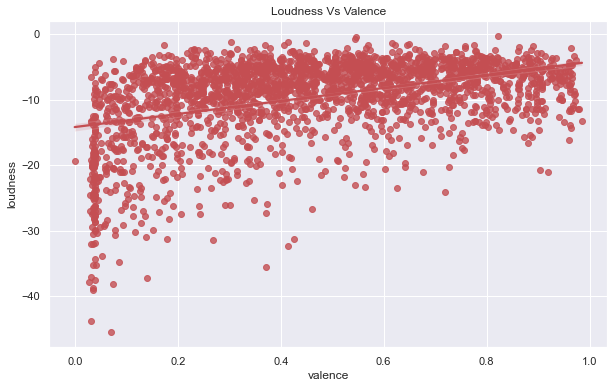

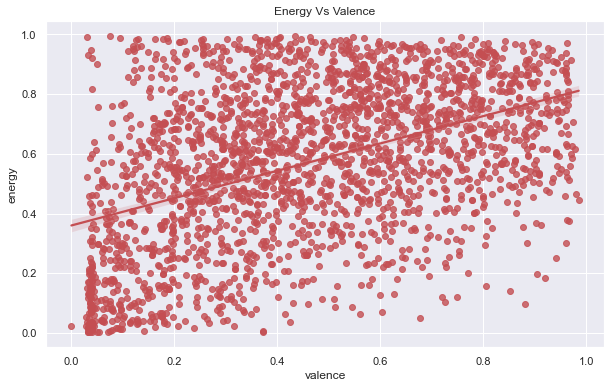

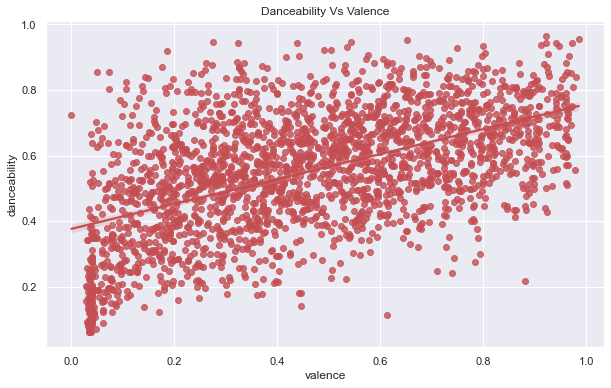

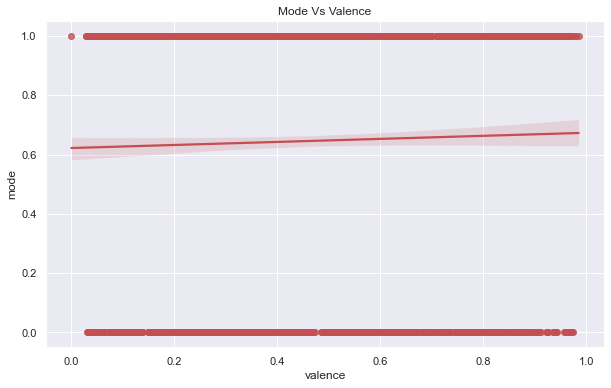

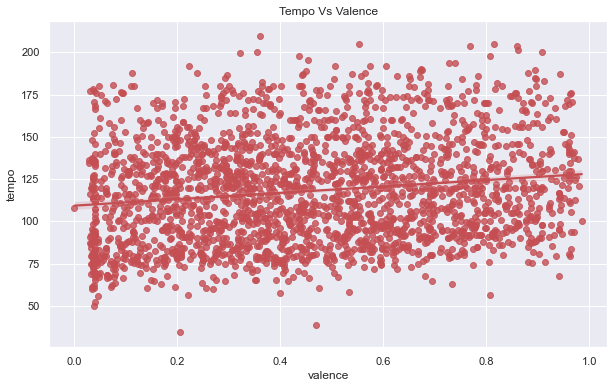

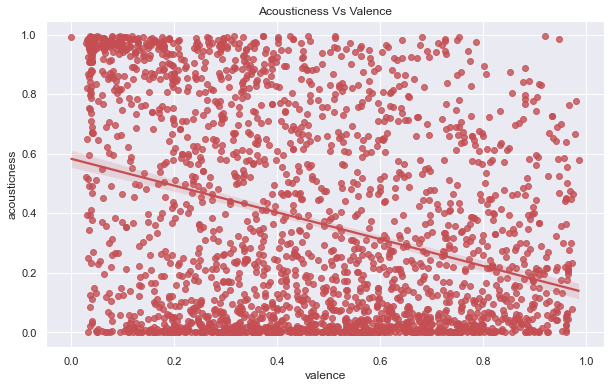

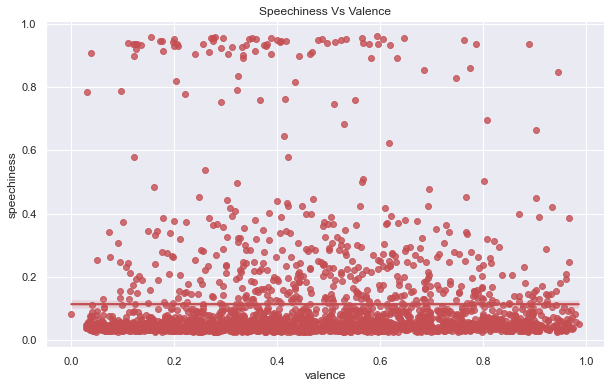

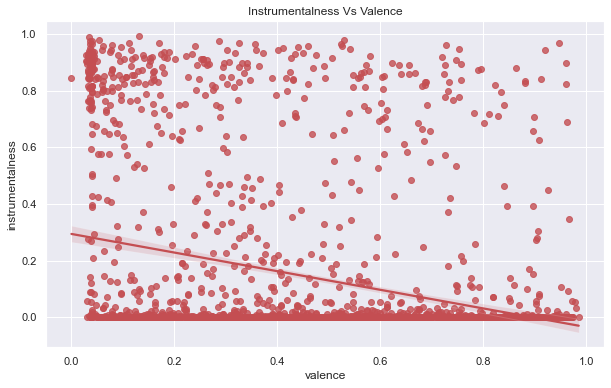

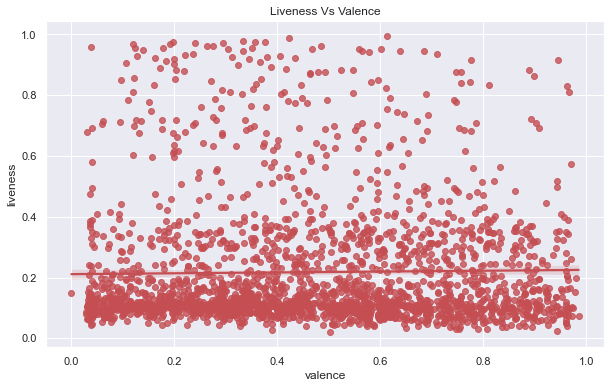

In [5]:
# import plot module
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

# dataset_path = 'dataset/hit_songs/spotify_hits_dataset_complete.csv'
dataset_path = 'dataset/SpotifyFeatures.csv'
test_dataset = 'dataset/spotify_ids.txt'

# initialize our object and get the foremost features of songs
spotify_handler = SpotifyHandler(dataset_path)
spotify_handler.drop_columns_list(spotify_handler.get_dataset(), ['genre'])
spotify_handler.sort_by_valence()

# get numerical data
valence_list = spotify_handler.get_tracks_valence()
energy_list = spotify_handler.get_tracks_energy()
loudness = spotify_handler.get_tracks_loudness()
mode = spotify_handler.get_tracks_mode()
danceability = spotify_handler.get_tracks_danceability()
tempo = spotify_handler.get_tracks_tempo()
acousticness = spotify_handler.get_tracks_acousticness()
speechiness = spotify_handler.get_tracks_speechiness()
instrumentalness = spotify_handler.get_tracks_instrumentalness()
liveness = spotify_handler.get_tracks_liveness()

# let's keep a 1% of our dataset (too much data to display properly) to plot data and a linear regression model fit between 2 features.
sample_df=spotify_handler.dataset.sample(int(0.01*len(spotify_handler.dataset)))

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='loudness', x='valence', color='r').set(title='Loudness Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='energy', x='valence', color='r').set(title='Energy Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='danceability', x='valence', color='r').set(title='Danceability Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='mode', x='valence', color='r').set(title='Mode Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='tempo', x='valence', color='r').set(title='Tempo Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='acousticness', x='valence', color='r').set(title='Acousticness Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='speechiness', x='valence', color='r').set(title='Speechiness Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='instrumentalness', x='valence', color='r').set(title='Instrumentalness Vs Valence')

plt.figure(figsize=(10,6))
sns.regplot(data=sample_df, y='liveness', x='valence', color='r').set(title='Liveness Vs Valence')

### Below we read our test dataset, but we have already fetched test track ids using spotipy and Spotify API, so we keep cell in comments. Test dataset is saved in a csv file, in order to skip time. You could find it in dataset directory.

In [6]:
# test_dataset = spotify_handler.fetch_data()
# test_df = pd.DataFrame(test_dataset)
# test_df.to_csv('dataset/test_data.csv', index=False)

### However, we cross-checked if the training dataset comprehend test data and we removed them.

In [7]:
print('Size of dataset before:', len(spotify_handler.get_dataset()) )
test_df = pd.read_csv('dataset/test_data.csv')
spotify_handler.remove_test_from_train(test_df)
print('Size of dataset after cross-check:', len(spotify_handler.get_dataset()) )

Size of dataset before: 232725
Size of dataset after cross-check: 232554


### Display our dataset (numerical only) stats

In [8]:
spotify_handler.keep_only_numerical().describe()

,valence,energy,loudness,danceability,tempo,acousticness,mode,speechiness,instrumentalness,liveness
count,232554.000000,232554.000000,232554.000000,232554.000000,232554.000000,232554.000000,232554.000000,232554.000000,232554.000000,232554.000000
mean,0.454847,0.570907,-9.571779,0.554306,117.664913,0.368640,0.652051,0.120798,0.148391,0.215046
std,0.260077,0.263497,5.999398,0.185632,30.899718,0.354800,0.476321,0.185574,0.302846,0.198320
min,0.000000,0.000020,-52.457000,0.056900,30.379000,0.000000,0.000000,0.022200,0.000000,0.009670
25%,0.237000,0.385000,-11.774000,0.435000,92.957000,0.037525,0.000000,0.036700,0.000000,0.097400
50%,0.444000,0.605000,-7.764000,0.571000,115.774500,0.232000,1.000000,0.050100,0.000044,0.128000
75%,0.660000,0.787000,-5.502000,0.692000,139.055500,0.723000,1.000000,0.105000,0.035900,0.264000
max,1.000000,0.999000,3.744000,0.989000,242.903000,0.996000,1.000000,0.967000,0.999000,1.000000


<AxesSubplot:>

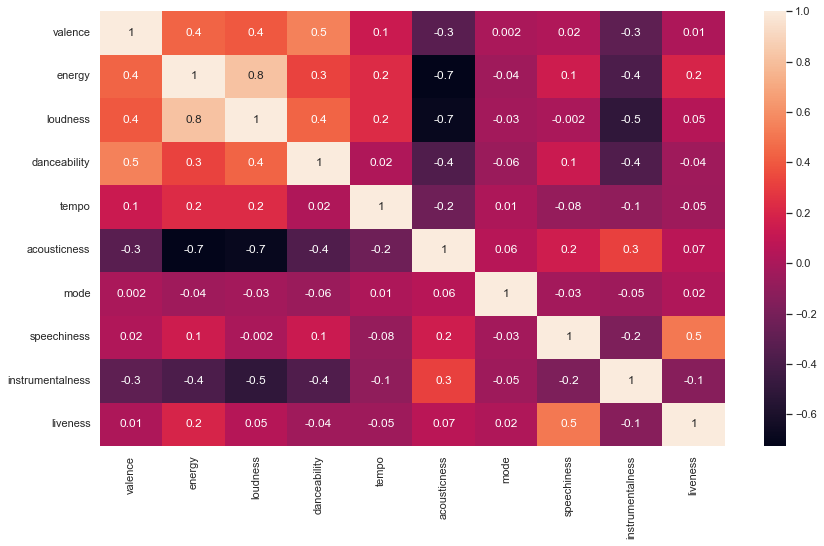

In [9]:
# correlation map from dataset
corr = spotify_handler.keep_only_numerical().corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True, fmt='.1g')

### As we want to investigate the correlation between valence and other variables (when we believe there is some kind of relationship among them), we 'll use the Pearson Correlation. If the relationship is not linear, but is nevertheless monotonic, then a different correlation coefficient, Spearman's rank correlation coefficient, or Spearman's  ρ , may be more appropriate. In this way, we are sure that everything is measured properly.

In [10]:
import scipy.stats.stats as stats
# apply statistical methods
print('Pearson loudness', stats.pearsonr(loudness, valence_list))
print(stats.spearmanr(loudness, valence_list))
print()
print('Pearson energy', stats.pearsonr(energy_list, valence_list))
print(stats.spearmanr(energy_list, valence_list))
print()
print('Pearson danceability', stats.pearsonr(danceability, valence_list))
print(stats.spearmanr(danceability, valence_list))
print()
print('Pearson mode', stats.pearsonr(mode, valence_list))
print(stats.spearmanr(mode, valence_list))
print()
print('Pearson tempo', stats.pearsonr(tempo, valence_list))
print(stats.spearmanr(tempo, valence_list))
print()
print('Pearson acousticness', stats.pearsonr(acousticness, valence_list))
print(stats.spearmanr(acousticness, valence_list))
print()
print('Pearson speechiness', stats.pearsonr(speechiness, valence_list))
print(stats.spearmanr(speechiness, valence_list))
print()
print('Pearson instrumentalness', stats.pearsonr(instrumentalness, valence_list))
print(stats.spearmanr(instrumentalness, valence_list))
print()
print('Pearson liveness', stats.pearsonr(liveness, valence_list))
print(stats.spearmanr(liveness, valence_list))
print()

Pearson loudness (0.3999013553088934, 0.0)
SpearmanrResult(correlation=0.3596146507333573, pvalue=0.0)

Pearson energy (0.4367711774372539, 0.0)
SpearmanrResult(correlation=0.4173762755613265, pvalue=0.0)

Pearson danceability (0.5471540203821303, 0.0)
SpearmanrResult(correlation=0.5297255585985869, pvalue=0.0)

Pearson mode (0.0017142621678114343, 0.4082465194429739)
SpearmanrResult(correlation=2.4795593228972556e-05, pvalue=0.9904561546149051)

Pearson tempo (0.13485722510473613, 0.0)
SpearmanrResult(correlation=0.13262379237877653, pvalue=0.0)

Pearson acousticness (-0.32579820331286646, 0.0)
SpearmanrResult(correlation=-0.28289665066909114, pvalue=0.0)

Pearson speechiness (0.02384162152384725, 1.2719032898839848e-30)
SpearmanrResult(correlation=0.1512219589366968, pvalue=0.0)

Pearson instrumentalness (-0.30752184670440535, 0.0)
SpearmanrResult(correlation=-0.28194696156330673, pvalue=0.0)

Pearson liveness (0.011804373546822837, 1.235281619664547e-08)
SpearmanrResult(correlation=

### We could conlcude from both heatmap and statistical measures (Pearman and Spearmanr) that the correlation between valence and danceability, energy, loudness is the highest among the other variables (highest correlation with energy). Therefore, danceability, energy and loudness gives us high valence (songs are happier).

## Now let's do ANOVA analysis with categorical variable key.

### First of all, we must check if the data in the groups follow the normal distribution.

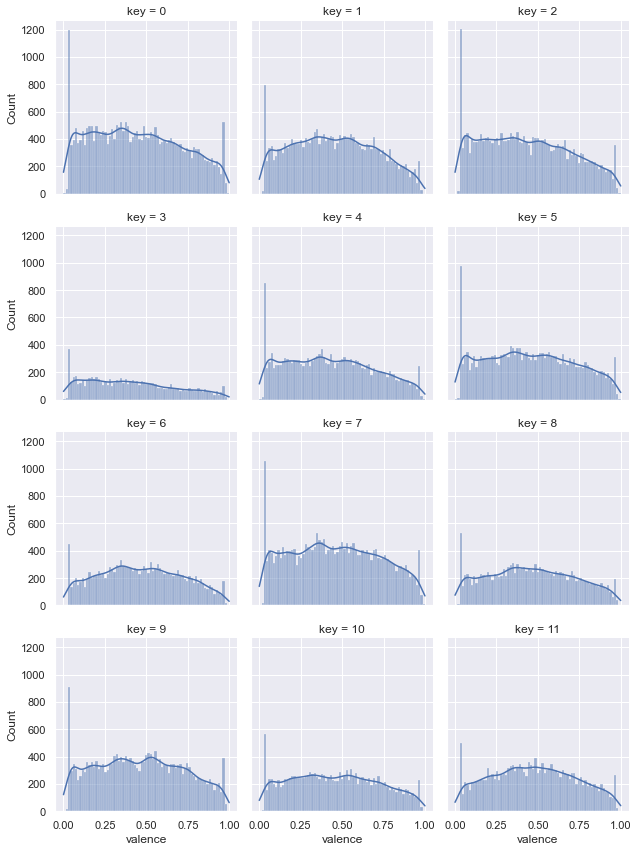

In [11]:
sns.set_theme()
sns.displot(
    spotify_handler.get_dataset(),
    kde=True,
    x="valence", col="key", col_wrap=3, height=3, facet_kws=dict(margin_titles=True),
)

## From the plot, we could reject the fact that the data in the groups follow the normal distribution, se we can not do ANOVA analysis to our dataset.

---
## Predict Valence based on track features, using SGDRegressor, RandomForestRegressor, XGBoostRegressor and 2 NN-based models (MLP, CNN) implemented using Keras (Tensorflow)
---

## We will use 3 different models for predicting valence. Each and every model is described from its title. First let's make our implementation of the class, which will help us to better handle the data. As far as the track features are concerned, we will keep only track features which corresponds to Spotify API. That is 'energy', 'loudness', 'danceability', 'tempo', 'acousticness', 'mode', 'speechiness', 'instrumentalness', 'liveness', 'key'. Furthermore we can observe that the dataset has different ranges in their variables. So we obviously we will Normalize the track features using Keras preprocessing Normalization.

In [12]:
spotify_dataset.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,...,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.652031,0.120765,...,0.075888,0.118522,0.099693,0.103457,0.032510,0.074723,0.087137,0.065408,0.113396,0.065137
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.476327,0.185518,...,0.264819,0.323226,0.299591,0.304555,0.177352,0.262945,0.282037,0.247244,0.317076,0.246768
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.000000,0.022200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.000000,0.036700,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,1.000000,0.050100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,1.000000,0.105000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,1.000000,0.967000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### For the occasion of our task, we will not use genre as our variable as it doesn't belong to Spotify's tracks' features.

In [13]:
!pip install xgboost
import numpy as np
import xgboost as xg
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error as MAE

# variables we keep.
data_names = ['energy', 'loudness', 'danceability', 'tempo', 'acousticness', 'mode', 'speechiness', 'instrumentalness', 'liveness',
            'key_0', 'key_1', 'key_2','key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9','key_10', 'key_11']


class MLRegressors:
    
    def __init__(self, dataset, name='sgd',  normalize=True):
        # initialize our object and get the foremost features of songs
        spotify_handler = SpotifyHandler(dataset_path)
        test_df = pd.read_csv('dataset/test_data.csv')
        # remove test data from train
        spotify_handler.remove_test_from_train(test_df)
        spotify_handler.sort_by_valence()
        # convert categorical variables to one-hot
        spotify_handler.convert_to_dummies()
        # init X, Y
        self.X_features = spotify_handler.get_specific_features()
        self.Y_target = spotify_handler.get_tracks_valence()
        # normalize dataset.
        self.normalizer = preprocessing.Normalization()
        self.ml_model = name
        if normalize:
            self.normalizer.adapt(self.X_features)
            self.X_features = self.normalizer(self.X_features).numpy()
    
    # SGDRegressor model
    def define_sgd(self, l_rate, max_iterations, tolerance, penalty):
        return SGDRegressor(max_iter=max_iterations, 
                            tol=tolerance, 
                            penalty=penalty,
                            eta0 = l_rate)
    # DecisionTreeRegressor model
    def define_decisiontree(self, max_depth):
        return DecisionTreeRegressor(max_depth=max_depth)
    
    # SVR (didn't use, too slow!)   
    def define_svr(self, C, tolerance, epsilon):
        return SVR(kernel='linear', C=C, tol=tolerance, epsilon=epsilon)
    
    # AdaBoostRegressor model
    def define_xgboost(self, n_estimators, max_depth, l_rate):
        return xg.XGBRegressor(objective ='reg:linear', n_estimators = n_estimators, eta = l_rate , max_depth=max_depth,  seed = 42)
    
    # make splits for training/validating
    def make_splits(self):
            x_train, x_val, y_train, y_val = train_test_split(self.X_features, self.Y_target, test_size = 0.2, random_state = 42)
            return x_train, x_val, y_train, y_val
    
    # hypertuning method for get the best hyperparameters for each model.
    # For this assignment and for less time, we used GridSearchCV with some parameters.
    def hypertuning(self, x_train, y_train):
        if self.ml_model == 'sgd':
            
            parameters = [
                {'eta0': [0.1, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005]}    # learning_rate
            ]
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            model = GridSearchCV(SGDRegressor(), parameters, cv=cv, verbose=1)


            model = model.fit(x_train, y_train)
            means = model.cv_results_['mean_test_score']
            stds = model.cv_results_['std_test_score']
            # display every score
            for mean, std, params in zip(means, stds, model.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
                
            return model.best_estimator_, model.best_params_

        
        elif self.ml_model == 'decisiontree':

            parameters = [
                  {'max_depth': list(range(1, 16))},
                 ]

            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            model = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv, verbose=1)

            model = model.fit(x_train, y_train)
    
            means = model.cv_results_['mean_test_score']
            stds = model.cv_results_['std_test_score']
            # display every score
            for mean, std, params in zip(means, stds, model.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
            return model.best_estimator_, model.best_params_

        
        elif self.ml_model == 'xgboost':
            
            parameters = [
                {'n_estimators': [100, 200, 300, 500]},
                {'max_depth': [10, 11, 12]},
                {'eta': [0.01, 0.1, 0.2, 0.3]}
            ]

            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            model = GridSearchCV( xg.XGBRegressor(objective ='reg:linear', seed = 42), parameters,cv = cv, verbose=1)


            model = model.fit(x_train, y_train)
            means = model.cv_results_['mean_test_score']
            stds = model.cv_results_['std_test_score']
            # display every score
            for mean, std, params in zip(means, stds, model.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
            return model.best_estimator_, model.best_params_
        
        # TOO SLOW DIDN'T USE!!!
        elif self.ml_model == 'svr':
            
            parameters = [
                {'C': [1.0, 10.0, 100.0, 1000.0]},
                {'tol': [1e-3, 1e-4, 1e-5]},
                {'epsilon': [0.1, 0.01, 0.5, 0.05]}
            ]
            
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            model = GridSearchCV(SVR(), parameters, cv=cv, verbose=1)


            model = model.fit(x_train, y_train)
            means = model.cv_results_['mean_test_score']
            stds = model.cv_results_['std_test_score']
            # display every score
            for mean, std, params in zip(means, stds, model.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
            return model.best_estimator_, model.best_params_

---
# SGD Regressor
---

In [14]:
regr = MLRegressors('dataset/SpotifyFeatures.csv', name='sgd')
x_train, x_val, y_train, y_val = regr.make_splits()
# random model
temp_model = regr.define_sgd(l_rate=0.01, max_iterations=1000, tolerance=1e-5, penalty='l2')
temp_model.fit(x_train, y_train)
print('Test in validation data:',temp_model.score(x_val, y_val))

Test in validation data: 0.4099151617928244


## Tuning SGD Regressor

In [15]:
%%time
best_model_sgd, best_params = regr.hypertuning(x_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.393 (+/-0.019) for {'eta0': 0.1}
0.412 (+/-0.004) for {'eta0': 0.01}
0.404 (+/-0.007) for {'eta0': 0.05}
0.414 (+/-0.004) for {'eta0': 0.001}
0.413 (+/-0.003) for {'eta0': 0.005}
0.399 (+/-0.002) for {'eta0': 0.0001}
0.414 (+/-0.003) for {'eta0': 0.0005}
Wall time: 11.2 s


## Display best model (score) with its feature importance

Best hyperparameters: {'eta0': 0.001}
Score: 0.41252949281661144

Feature: 0, Score: 0.14093
Feature: 1, Score: -0.05328
Feature: 2, Score: 0.13428
Feature: 3, Score: 0.01694
Feature: 4, Score: 0.04738
Feature: 5, Score: 0.00740
Feature: 6, Score: -0.04118
Feature: 7, Score: -0.02489
Feature: 8, Score: -0.00074
Feature: 9, Score: 0.00058
Feature: 10, Score: -0.00797
Feature: 11, Score: -0.00156
Feature: 12, Score: 0.00141
Feature: 13, Score: -0.00139
Feature: 14, Score: 0.00479
Feature: 15, Score: -0.00107
Feature: 16, Score: 0.00284
Feature: 17, Score: -0.00085
Feature: 18, Score: 0.00183
Feature: 19, Score: 0.00234
Feature: 20, Score: -0.00042


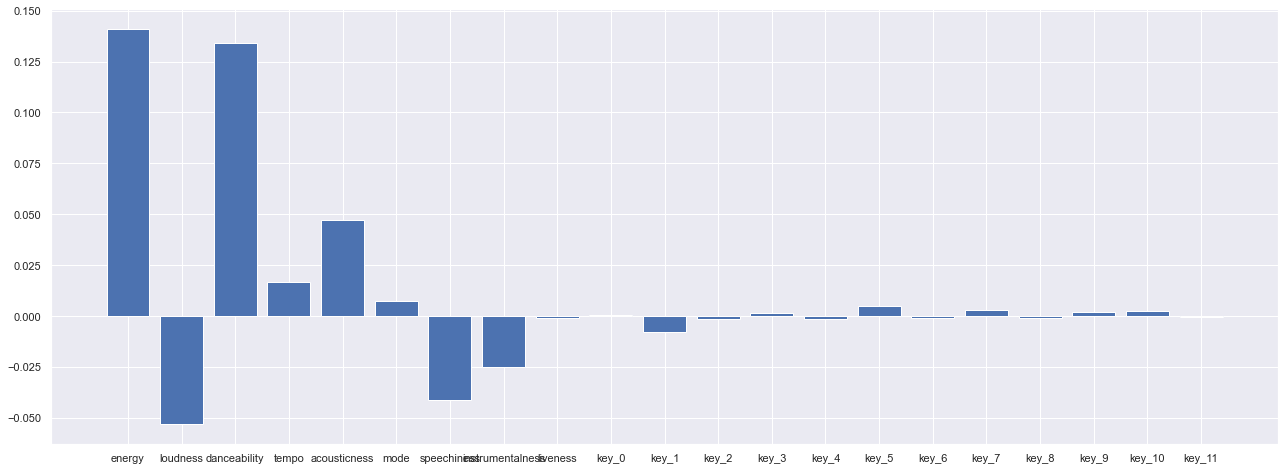

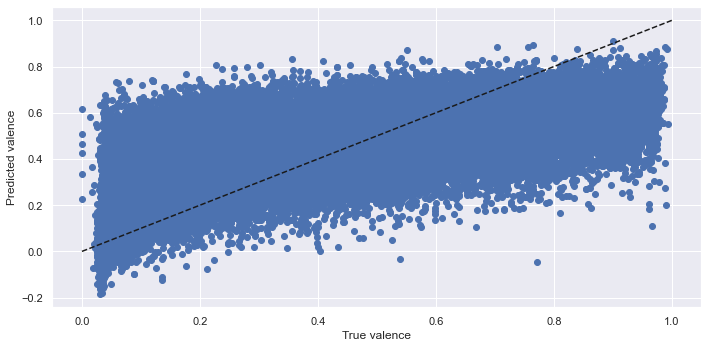

In [16]:
print('Best hyperparameters:', best_params)

print('Score:',best_model_sgd.score(x_val, y_val))
print()

importance = best_model_sgd.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(22, 8))
plt.bar([x for x in range(len(importance))], importance,
    tick_label=[data_names[x] for x in range(len(importance))])
plt.show()


# making predictions on the test data
predicted = best_model_sgd.predict(x_val)
# plotting the best-fit line
plt.figure(figsize=(10, 5))
plt.scatter(y_val, predicted)
plt.plot([0, 1], [0, 1], '--k')
plt.axis('tight')
plt.xlabel('True valence')
plt.ylabel('Predicted valence')
plt.tight_layout()

### In SGD Regression, energy and danceability are the most significant features in predicting valence of tracks.

---
# Decision Tree Regressor
---

In [17]:
regr = MLRegressors('dataset/SpotifyFeatures.csv', name='decisiontree')
x_train, x_val, y_train, y_val = regr.make_splits()
# random model
temp_model = regr.define_decisiontree(max_depth=6)
temp_model.fit(x_train, y_train)
print('Test in validation data:',temp_model.score(x_val, y_val))

Test in validation data: 0.4042305187206253


## Tuning Decision Tree Regressor

In [18]:
%%time
best_model_dt, best_params = regr.hypertuning(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.208 (+/-0.006) for {'max_depth': 1}
0.300 (+/-0.002) for {'max_depth': 2}
0.350 (+/-0.003) for {'max_depth': 3}
0.373 (+/-0.003) for {'max_depth': 4}
0.390 (+/-0.004) for {'max_depth': 5}
0.407 (+/-0.004) for {'max_depth': 6}
0.419 (+/-0.006) for {'max_depth': 7}
0.430 (+/-0.005) for {'max_depth': 8}
0.442 (+/-0.007) for {'max_depth': 9}
0.448 (+/-0.006) for {'max_depth': 10}
0.451 (+/-0.004) for {'max_depth': 11}
0.450 (+/-0.005) for {'max_depth': 12}
0.446 (+/-0.006) for {'max_depth': 13}
0.438 (+/-0.008) for {'max_depth': 14}
0.427 (+/-0.009) for {'max_depth': 15}
Wall time: 1min 11s


## Display best model (score) and its feature importance

Best hyperparameters: {'max_depth': 11}
Score: 0.452820848781156

Feature: 0, Score: 0.21068
Feature: 1, Score: 0.03677
Feature: 2, Score: 0.56180
Feature: 3, Score: 0.03778
Feature: 4, Score: 0.03482
Feature: 5, Score: 0.00143
Feature: 6, Score: 0.05738
Feature: 7, Score: 0.02249
Feature: 8, Score: 0.03337
Feature: 9, Score: 0.00007
Feature: 10, Score: 0.00124
Feature: 11, Score: 0.00035
Feature: 12, Score: 0.00021
Feature: 13, Score: 0.00035
Feature: 14, Score: 0.00010
Feature: 15, Score: 0.00022
Feature: 16, Score: 0.00023
Feature: 17, Score: 0.00014
Feature: 18, Score: 0.00015
Feature: 19, Score: 0.00012
Feature: 20, Score: 0.00031


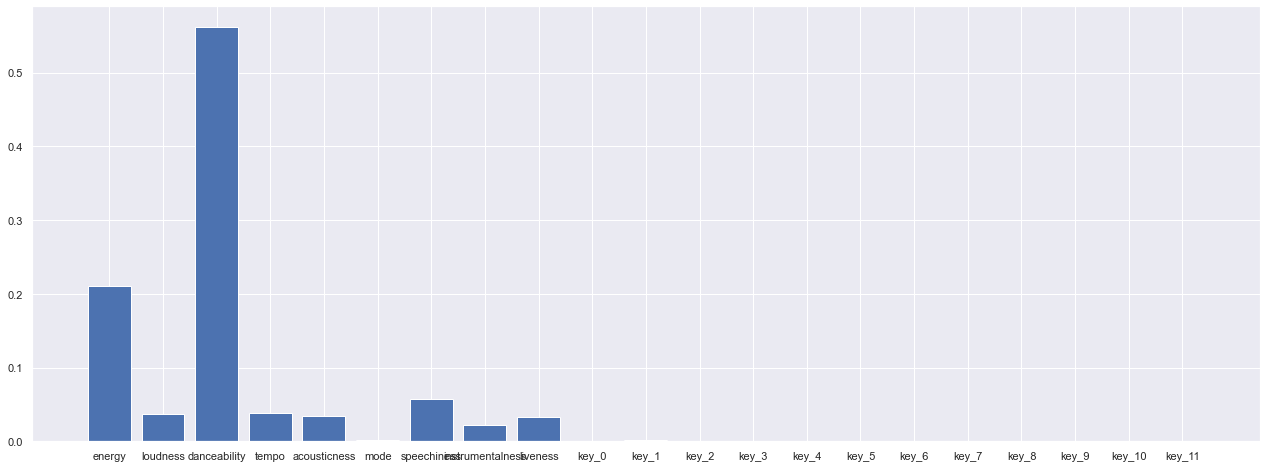

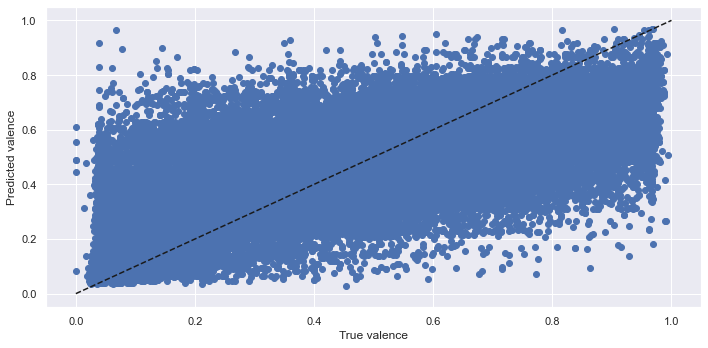

In [19]:
print('Best hyperparameters:', best_params)

print('Score:',best_model_dt.score(x_val, y_val))
print()

importance = best_model_dt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(22, 8))
plt.bar([x for x in range(len(importance))], importance,
    tick_label=[data_names[x] for x in range(len(importance))])
plt.show()


# making predictions on the test data
predicted = best_model_dt.predict(x_val)
# plotting the best-fit line
plt.figure(figsize=(10, 5))
plt.scatter(y_val, predicted)
plt.plot([0, 1], [0, 1], '--k')
plt.axis('tight')
plt.xlabel('True valence')
plt.ylabel('Predicted valence')
plt.tight_layout()

### In Decision Tree Regression, danceability is the most significant feature in predicting valence of tracks.

---
# XGBoost Regressor
---

In [20]:
regr = MLRegressors('dataset/SpotifyFeatures.csv', name='xgboost')
x_train, x_val, y_train, y_val = regr.make_splits()
# random model
temp_model = regr.define_xgboost(n_estimators=500, max_depth=10, l_rate=0.2)
temp_model.fit(x_train, y_train)
print('Test in validation data:',temp_model.score(x_val, y_val))

[16:14:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Test in validation data: 0.6596506970667794


## Tuning XGBoost Regressor (~10mins run)

In [21]:
%%time
best_model_xgb, best_params = regr.hypertuning(x_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[16:15:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:00] WARNING: C:/Users/Administrator/workspace/x

## Display best model (score) and its feature importance

Best hyperparameters: {'max_depth': 12}
Score: 0.636452459834

Feature: 0, Score: 0.06048
Feature: 1, Score: 0.03876
Feature: 2, Score: 0.21596
Feature: 3, Score: 0.05027
Feature: 4, Score: 0.04766
Feature: 5, Score: 0.03651
Feature: 6, Score: 0.05971
Feature: 7, Score: 0.05016
Feature: 8, Score: 0.04902
Feature: 9, Score: 0.02746
Feature: 10, Score: 0.04964
Feature: 11, Score: 0.03266
Feature: 12, Score: 0.02932
Feature: 13, Score: 0.03392
Feature: 14, Score: 0.03365
Feature: 15, Score: 0.03509
Feature: 16, Score: 0.02856
Feature: 17, Score: 0.03270
Feature: 18, Score: 0.02906
Feature: 19, Score: 0.02860
Feature: 20, Score: 0.03082


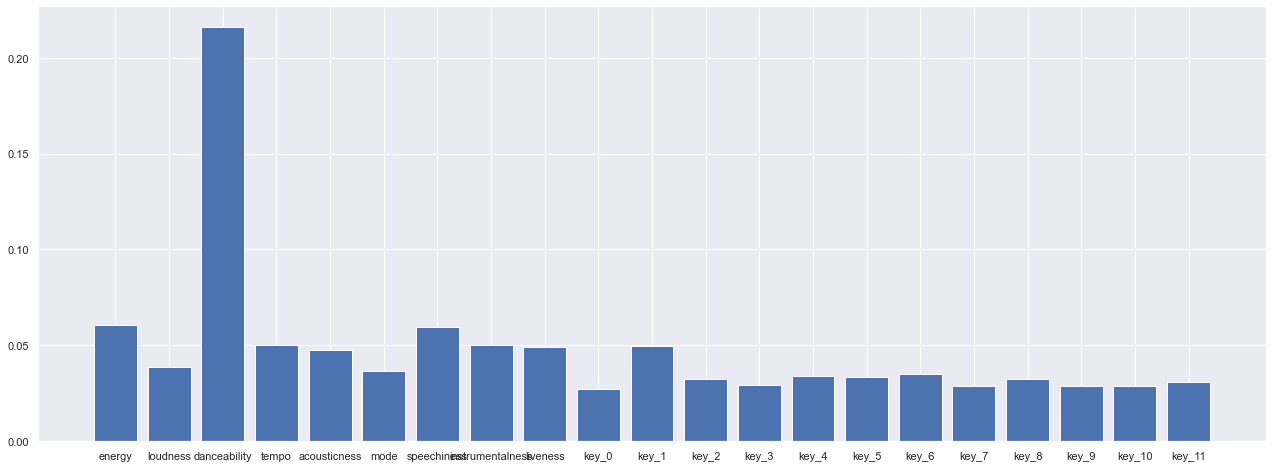

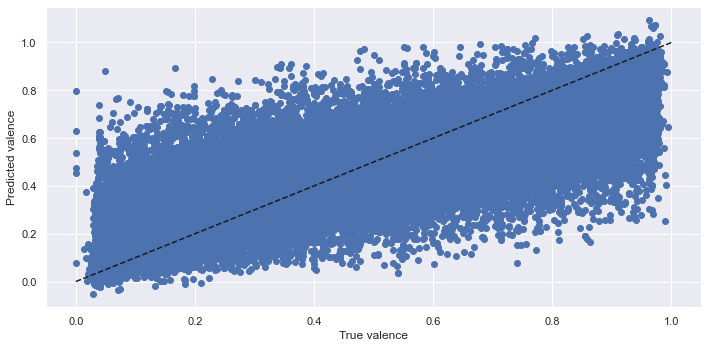

In [22]:
from sklearn.metrics import r2_score
print('Best hyperparameters:', best_params)

predicted = best_model_xgb.predict(x_val)
print('Score:', r2_score(y_val,predicted))
print()

importance = best_model_xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(22, 8))
plt.bar([x for x in range(len(importance))], importance,
    tick_label=[data_names[x] for x in range(len(importance))])
plt.show()


# plotting the best-fit line
plt.figure(figsize=(10, 5))
plt.scatter(y_val, predicted)
plt.plot([0, 1], [0, 1], '--k')
plt.axis('tight')
plt.xlabel('True valence')
plt.ylabel('Predicted valence')
plt.tight_layout()

### In XGBoost Regression, danceability is the most significant feature in predicting valence of tracks.

# Now let's 2 NN-based model. There a lot of ways to define our models using some interesting toolkits like Tensorflow or Pytorch. For this task, we will use Tensorflow (Keras).

In [23]:
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Input, Flatten, Dropout, Conv2D, BatchNormalization, Activation, Reshape, Conv1D, GlobalMaxPooling1D
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing



class CustomModel:
    
    def __init__(self, dataset_path, use_dropout, normalize=True):
        # initialize our object and get the foremost features of songs
        spotify_handler = SpotifyHandler(dataset_path)
        test_df = pd.read_csv('dataset/test_data.csv')
        # remove test data from train
        spotify_handler.remove_test_from_train(test_df)
        spotify_handler.sort_by_valence()
        # convert categorical variables to one-hot
        spotify_handler.convert_to_dummies()
        
        # init X, Y
        self.X_features = spotify_handler.get_specific_features()
        self.Y_target = np.array(spotify_handler.get_tracks_valence())
        # normalize
        self.normalizer = preprocessing.Normalization()
        if normalize:
            self.normalizer.adapt(self.X_features)
            self.X_features = self.normalizer(self.X_features).numpy()
        # dropout flag
        self.dropout = use_dropout
        self.shape = self.X_features.shape[1]
    
    # keep data for training/validating/testing
    def make_splits(self):
        x_train, x_val, y_train, y_val = train_test_split(self.X_features, self.Y_target, test_size = 0.2, random_state = 42)
        return x_train, x_val, y_train, y_val
    
    # we define MLP and CNN for prediction
    def define_model(self, optimizer, loss, option = 'mlp', display=True):
        
        if option == 'mlp':
            #################### MLP ###########################
            inputs = Input((self.shape, ))
            x = Dense(64, activation='relu')(inputs)
            x = Dense(128, activation='relu')(x)
            x = Dense(256, activation='relu')(x)
            x = Dense(128, activation='relu')(x)
            x = Dense(64, activation='relu')(x)
            if self.dropout:
                x = Dropout(0.2)(x)
            output = Dense(1)(x)
        
        ###################### CNN ####################
        elif option == 'cnn':
            inputs = Input((self.shape, ))
            x = Reshape((self.shape, 1))(inputs)
            x = Conv1D(128, kernel_size = 7, activation="relu")(x)
            x = BatchNormalization()(x)
            if self.dropout:
                x = Dropout(0.1)(x)
            x = Conv1D(64, kernel_size = 5, activation="relu")(x)
            x = BatchNormalization()(x)
            if self.dropout:
                x = Dropout(0.1)(x)
            x = Conv1D(64, kernel_size = 3, activation="relu")(x)
            x = BatchNormalization()(x)
            if self.dropout:
                x = Dropout(0.1)(x)
            x = GlobalMaxPooling1D()(x)
            x = Dense(128, activation='relu')(x)
            x = Dense(64, activation='relu')(x)
            output = Dense(1)(x)

        model = Model(inputs=[inputs], outputs = output)
        model.compile(optimizer=optimizer,loss=loss)
        if display:
            print(model.summary())
        return model
    
    # train method
    def _train(self, x_train, y_train, x_val, y_val, option, learning_rate, loss):
        OPTIMIZER = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
        LOSS = loss
        MODEL = self.define_model(OPTIMIZER, LOSS, option)
        
        # patience for 10 epochs
        early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        
        # reduce learning rate
        reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1,
                                                         mode='min')
        # callbacks
        cs = [early, reduce_lr]
        
        EPOCHS = 100
        history = MODEL.fit(
            x = x_train,
            y = y_train,
            epochs = EPOCHS,
            batch_size=64,
            verbose=1,
            validation_data = (x_val, y_val),
            callbacks=cs
        )
        return history, MODEL
        
        
        

## Train MLP

In [24]:
dataset_path = 'dataset/SpotifyFeatures.csv'
test_dataset = 'dataset/spotify_ids.txt'

NN = CustomModel(dataset_path, use_dropout=True)
x_train, x_val, y_train, y_val = NN.make_splits()
history, MLP = NN._train(x_train, y_train, x_val, y_val, 'mlp', 0.001, 'mae')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 64)                1408      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [25]:
from sklearn.metrics import r2_score
y_pred = MLP.predict(x_val, verbose=0)
print('Validation R^2 score:',r2_score(y_val,y_pred))

Validation R^2 score: 0.5105033692067192


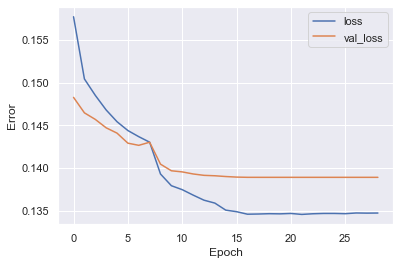

In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

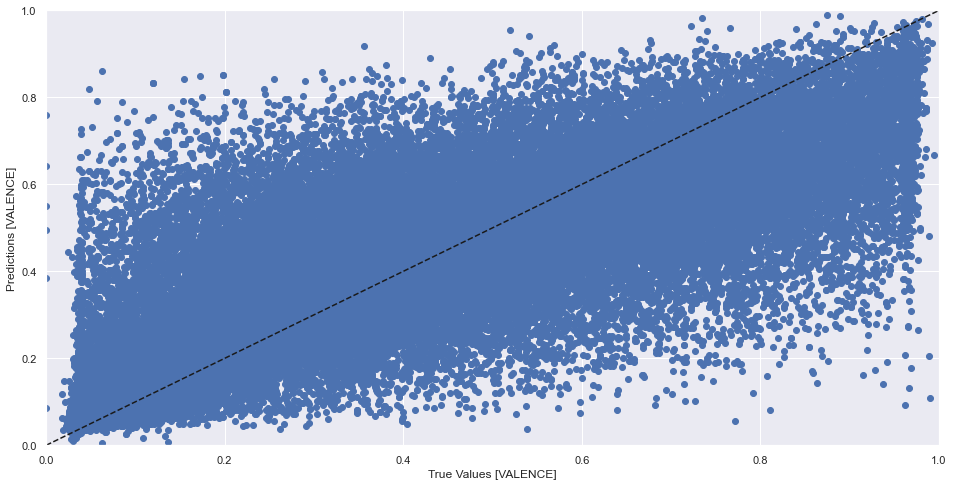

In [27]:
test_predictions = MLP.predict(x_val).flatten()

plt.figure(figsize=(16, 8))
plt.scatter(y_val, test_predictions)
plt.xlabel('True Values [VALENCE]')
plt.ylabel('Predictions [VALENCE]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, 'k--')

## Train CNN

In [28]:
dataset_path = 'dataset/SpotifyFeatures.csv'
test_dataset = 'dataset/spotify_ids.txt'

NN2 = CustomModel(dataset_path, use_dropout=True)
history, CNN = NN2._train(x_train, y_train, x_val, y_val, 'cnn', 0.001, 'mae')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 reshape (Reshape)           (None, 21, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 15, 128)           1024      
                                                                 
 batch_normalization (BatchN  (None, 15, 128)          512       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 15, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                           

In [29]:
from sklearn.metrics import r2_score
y_pred = CNN.predict(x_val, verbose=0)
print('Validation R^2 score:',r2_score(y_val,y_pred))

Validation R^2 score: 0.5001369135731177


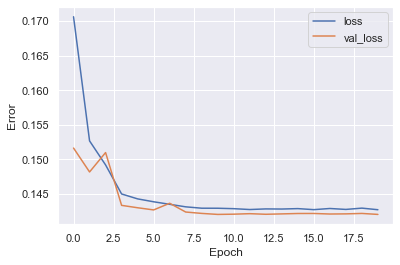

In [30]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

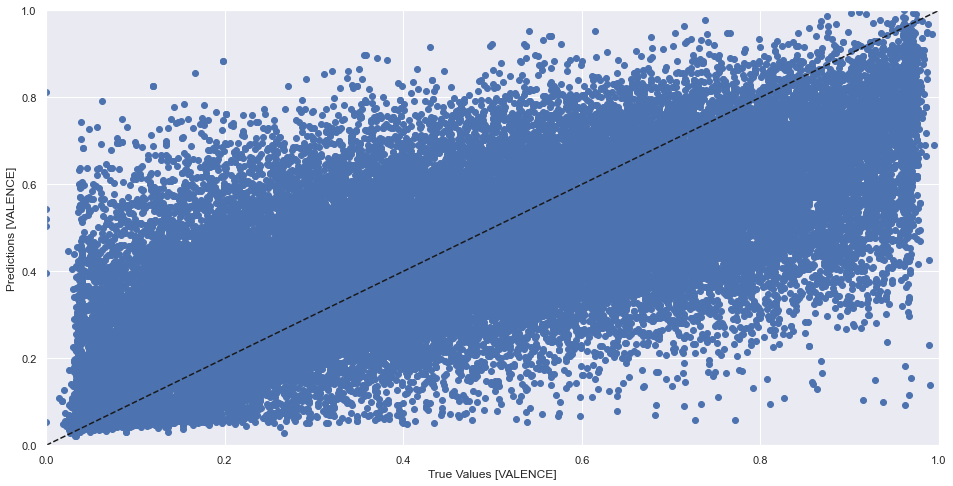

In [31]:
test_predictions = CNN.predict(x_val).flatten()

plt.figure(figsize=(16, 8))
plt.scatter(y_val, test_predictions)
plt.xlabel('True Values [VALENCE]')
plt.ylabel('Predictions [VALENCE]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, 'k--')

# Let's find best model with the best MAE among all.

## Below, we define the best model for R^2 I found.

In [32]:
BEST_R2 = regr.define_xgboost(n_estimators=1500, max_depth=10, l_rate=0.2)
BEST_R2.fit(x_train, y_train)
print('Test in validation data:',BEST_R2.score(x_val, y_val))

[16:36:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Test in validation data: 0.6806054341254657


## Test best models we got

In [33]:
from sklearn.metrics import mean_absolute_error as MAE

# read test dataset
test_df = pd.read_csv('dataset/test_data.csv')
# drop unwanted columns
test_df = test_df.drop( ['type','id','uri','track_href','analysis_url','duration_ms','time_signature'], axis=1 )
# convert key to dummies
test_df = pd.get_dummies(test_df, columns=['key'], sparse=False)

# split into x_test/y_test
y_test = test_df['valence']
x_test = test_df[['energy', 'loudness', 'danceability', 'tempo', 'acousticness', 'mode', 'speechiness', 'instrumentalness', 'liveness',
            'key_0', 'key_1', 'key_2','key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9','key_10', 'key_11']]
# and normalize data
x_test= regr.normalizer(x_test).numpy()

# function which calculates best MAE score among best defined models
def find_best_model(x_test, y_test):
    MAE_SCORES = []
    BEST_MODELS = [best_model_sgd, best_model_dt, best_model_xgb, MLP, CNN, BEST_R2]
    for bestmodel in BEST_MODELS:
        best_model_predictions = bestmodel.predict(x_test)
        MAE_SCORES.append(MAE(y_test, best_model_predictions))
    return MAE_SCORES

## Get best model with the best MAE

In [34]:
MAE_SCORES = find_best_model(x_test, y_test)
BEST_MODEL_NAMES = ['SGD', 'DT', 'XGB', 'MLP', 'CNN', 'BR2']
print('Best MAE:', BEST_MODEL_NAMES[np.argmin(MAE_SCORES)], MAE_SCORES[np.argmin(MAE_SCORES)])

Best MAE: CNN 0.1450779471459159


# Finally, the best model giving the lowest MAE is displayed above.